In [ ]:
# calculate the time 
import time  
notebook_start = time.time()

In [2]:
# install required packages
%pip install catboost
%pip install h3-py 
%pip install geopy
%pip install h3
%pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 36.8 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement h3-py (from versions: none)
ERROR: No matching distribution found for h3-py
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
# import required packages
from geopy.distance import geodesic
import h3
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

In [7]:
# load the data
df = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample = pd.read_csv('SampleSubmission.csv')
variable_difinition = pd.read_csv('variable_descriptions.csv')

In [5]:
# show the training data
df.head()

ward  total_households  total_individuals     target     dw_00  \
0  41601001: Ward 1        1674.45058         5888.20750  16.773757  0.933841   
1  41601002: Ward 2        1736.99230         6735.33812  21.496661  0.696940   
2  41601003: Ward 3        2403.57591         7273.04995  10.931425  0.810545   
3  41601004: Ward 4        1740.78737         5734.49046  23.119257  0.659914   
4  41601005: Ward 5        1730.51451         6657.23835  13.652252  0.950575   

      dw_01     dw_02     dw_03     dw_04     dw_05  ...     pw_03     pw_04  \
0  0.000846  0.005490  0.000676  0.000000  0.001372  ...  0.002848  0.007537   
1  0.001253  0.004402  0.000000  0.002301  0.001323  ...  0.014566  0.057127   
2  0.004517  0.008891  0.003986  0.007735  0.000956  ...  0.057560  0.010358   
3  0.000000  0.006129  0.000000  0.000813  0.037245  ...  0.000000  0.000669   
4  0.000655  0.001473  0.000598  0.006999  0.000818  ...  0.004859  0.001290   

      pw_05     pw_06  pw_07  pw_08  ADM4_PCODE        lat        lon  \
0  0.000000  0.012928      0      0   ZA4161001 -29.682270  24.734743   
1  0.019092  0.004131      0      0   ZA4161002 -29.119311  24.757737   
2  0.001421  0.040881      0      0   ZA4161003 -29.142276  25.094093   
3  0.000000  0.005011      0      0   ZA4161004 -29.372052  24.942867   
4  0.000673  0.017629      0      0   ZA4161005 -29.409381  25.290165   

         NL  
0  0.292039  
1  3.207775  
2  0.000000  
3  2.038778  
4  0.000000  

[5 rows x 63 columns]

In [6]:
# # show testing data
test.head()

ward  total_households  total_individuals     dw_00     dw_01  \
0  21001001: Ward 1        2504.95194         8745.15151  0.947257  0.000873   
1  21001002: Ward 2        2080.27718         7258.11764  0.844993  0.000481   
2  21001003: Ward 3        1106.62639         5919.13170  0.651380  0.007937   
3  21001004: Ward 4        2175.56096        10280.57452  0.410837  0.002468   
4  21001005: Ward 5        1270.83883         6018.34202  0.942851  0.002638   

      dw_02     dw_03     dw_04     dw_05     dw_06  ...     pw_03     pw_04  \
0  0.002021  0.000000  0.000000  0.030116  0.000452  ...  0.001757  0.000000   
1  0.043629  0.004714  0.012323  0.012300  0.022132  ...  0.000691  0.000000   
2  0.007113  0.000000  0.001977  0.259711  0.006505  ...  0.002253  0.000000   
3  0.011511  0.000485  0.000000  0.449604  0.009256  ...  0.000000  0.000661   
4  0.000821  0.000000  0.000891  0.000787  0.000830  ...  0.000000  0.000000   

   pw_05     pw_06  pw_07  pw_08  ADM4_PCODE        lat        lon        NL  
0    0.0  0.006649    0.0    0.0   ZA2101001 -32.637758  23.848688  0.000000  
1    0.0  0.002916    0.0    0.0   ZA2101002 -31.990536  24.555818  0.000000  
2    0.0  0.000000    0.0    0.0   ZA2101003 -32.283595  24.563940  8.269556  
3    0.0  0.001379    0.0    0.0   ZA2101004 -32.261612  24.542202  8.626625  
4    0.0  0.001660    0.0    0.0   ZA2101005 -32.251571  24.558537  8.601754  

[5 rows x 62 columns]

In [7]:
variable_difinition

Column                                        Description  \
0        dw_00  Percentage of dwellings of type: House or bric...   
1        dw_01  Percentage of dwellings of type: Traditional d...   
2        dw_02  Percentage of dwellings of type: Flat or apart...   
3        dw_03  Percentage of dwellings of type: Cluster house...   
4        dw_04  Percentage of dwellings of type: Townhouse (se...   
5        dw_05  Percentage of dwellings of type: Semi-detached...   
6        dw_06  Percentage of dwellings of type: House/flat/ro...   
7        dw_07  Percentage of dwellings of type: Informal dwel...   
8        dw_08  Percentage of dwellings of type: Informal dwel...   
9        dw_09  Percentage of dwellings of type: Room/flatlet ...   
10       dw_10      Percentage of dwellings of type: Caravan/tent   
11       dw_11             Percentage of dwellings of type: Other   
12       dw_12       Percentage of dwellings of type: Unspecified   
13       dw_13    Percentage of dwellings of type: Not applicable   
14      psa_00  Percentage listing present school attendance a...   
15      psa_01  Percentage listing present school attendance a...   
16      psa_02  Percentage listing present school attendance a...   
17      psa_03  Percentage listing present school attendance a...   
18      psa_04  Percentage listing present school attendance a...   
19      stv_00   Percentage of households with Satellite TV:  Yes   
20      stv_01    Percentage of households with Satellite TV:  No   
21      car_00          Percentage of households with a car:  Yes   
22      car_01           Percentage of households with a car:  No   
23      lln_00     Percentage listing landline ownership as:  Yes   
24      lln_01      Percentage listing landline ownership as:  No   
25      lan_00         Percentage listing language as:  Afrikaans   
26      lan_01           Percentage listing language as:  English   
27      lan_02        Percentage listing language as:  IsiNdebele   
28      lan_03          Percentage listing language as:  IsiXhosa   
29      lan_04           Percentage listing language as:  IsiZulu   
30      lan_05            Percentage listing language as:  Sepedi   
31      lan_06           Percentage listing language as:  Sesotho   
32      lan_07          Percentage listing language as:  Setswana   
33      lan_08     Percentage listing language as:  Sign language   
34      lan_09           Percentage listing language as:  SiSwati   
35      lan_10         Percentage listing language as:  Tshivenda   
36      lan_11          Percentage listing language as:  Xitsonga   
37      lan_12             Percentage listing language as:  Other   
38      lan_13       Percentage listing language as:  Unspecified   
39      lan_14    Percentage listing language as:  Not applicable   
40       pg_00     Percentage in population group:  Black African   
41       pg_01          Percentage in population group:  Coloured   
42       pg_02   Percentage in population group:  Indian or Asian   
43       pg_03             Percentage in population group:  White   
44       pg_04             Percentage in population group:  Other   
45      lgt_00          Percentage using electricity for lighting   
46       pw_00  Percentage with piped water access:  Piped (ta...   
47       pw_01  Percentage with piped water access:  Piped (ta...   
48       pw_02  Percentage with piped water access:  Piped (ta...   
49       pw_03  Percentage with piped water access:  Piped (ta...   
50       pw_04  Percentage with piped water access:  Piped (ta...   
51       pw_05  Percentage with piped water access:  Piped (ta...   
52       pw_06  Percentage with piped water access:  No access...   
53       pw_07   Percentage with piped water access:  Unspecified   
54       pw_08  Percentage with piped water access:  Not appli...   
55  ADM4_PCODE  Code for linking row to ward in the wards shap...   
56         lat          Lattitude of the center point of the ward   
57    

In [8]:
# change the column names to be more descriptive
# Dictionary to store new column names
rename_dict = {}
used_names = set()

# Iterate through the description file
for _, row in variable_difinition.iterrows():
    col_name = row["Column"]
    if col_name in df.columns or col_name in test.columns:
        description = row["Description"]
        new_name = description.split(":")[0]  # Extract text before ':'
        
        # Ensure unique column names using .1, .2, etc., starting with base name first
        if new_name in used_names:
            counter = 1
            while f"{new_name}.{counter}" in used_names:
                counter += 1
            new_name = f"{new_name}.{counter}"
        
        used_names.add(new_name)
        rename_dict[col_name] = new_name

# Rename columns in the train dataset
df.rename(columns=rename_dict, inplace=True)
test.rename(columns=rename_dict, inplace=True)


In [9]:
df.head()

ward  total_households  total_individuals  \
0  41601001: Ward 1        1674.45058         5888.20750   
1  41601002: Ward 2        1736.99230         6735.33812   
2  41601003: Ward 3        2403.57591         7273.04995   
3  41601004: Ward 4        1740.78737         5734.49046   
4  41601005: Ward 5        1730.51451         6657.23835   

   Percentage of women head households with income under R19.6k out of total number of households  \
0                                          16.773757                                                
1                                          21.496661                                                
2                                          10.931425                                                
3                                          23.119257                                                
4                                          13.652252                                                

   Percentage of dwellings of type  Percentage of dwellings of type.1  \
0                         0.933841                           0.000846   
1                         0.696940                           0.001253   
2                         0.810545                           0.004517   
3                         0.659914                           0.000000   
4                         0.950575                           0.000655   

   Percentage of dwellings of type.2  Percentage of dwellings of type.3  \
0                           0.005490                           0.000676   
1                           0.004402                           0.000000   
2                           0.008891                           0.003986   
3                           0.006129                           0.000000   
4                           0.001473                           0.000598   

   Percentage of dwellings of type.4  Percentage of dwellings of type.5  ...  \
0                           0.000000                           0.001372  ...   
1                           0.002301                           0.001323  ...   
2                           0.007735                           0.000956  ...   
3                           0.000813                           0.037245  ...   
4                           0.006999                           0.000818  ...   

   Percentage with piped water access.3  Percentage with piped water access.4  \
0                              0.002848                              0.007537   
1                              0.014566                              0.057127   
2                              0.057560                              0.010358   
3                              0.000000                              0.000669   
4                              0.004859                              0.001290   

   Percentage with piped water access.5  Percentage with piped water access.6  \
0                              0.000000                              0.012928   
1                              0.019092                              0.004131   
2                              0.001421                              0.040881   
3                              0.000000                              0.005011   
4                              0.000673                              0.017629   

   Percentage with piped water access.7  Percentage with piped water access.8  \
0                                     0                                     0   
1                                     0                                     0   
2                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   

   Code for linking row to ward in the wards shapefile  \
0                                          ZA4161001     
1                                          ZA4161002     
2                                        

In [10]:
# change the target name
df.rename(columns={'Percentage of women head households with income under R19.6k out of total number of households': 'target'}, inplace=True)

In [11]:
df.head()

ward  total_households  total_individuals     target  \
0  41601001: Ward 1        1674.45058         5888.20750  16.773757   
1  41601002: Ward 2        1736.99230         6735.33812  21.496661   
2  41601003: Ward 3        2403.57591         7273.04995  10.931425   
3  41601004: Ward 4        1740.78737         5734.49046  23.119257   
4  41601005: Ward 5        1730.51451         6657.23835  13.652252   

   Percentage of dwellings of type  Percentage of dwellings of type.1  \
0                         0.933841                           0.000846   
1                         0.696940                           0.001253   
2                         0.810545                           0.004517   
3                         0.659914                           0.000000   
4                         0.950575                           0.000655   

   Percentage of dwellings of type.2  Percentage of dwellings of type.3  \
0                           0.005490                           0.000676   
1                           0.004402                           0.000000   
2                           0.008891                           0.003986   
3                           0.006129                           0.000000   
4                           0.001473                           0.000598   

   Percentage of dwellings of type.4  Percentage of dwellings of type.5  ...  \
0                           0.000000                           0.001372  ...   
1                           0.002301                           0.001323  ...   
2                           0.007735                           0.000956  ...   
3                           0.000813                           0.037245  ...   
4                           0.006999                           0.000818  ...   

   Percentage with piped water access.3  Percentage with piped water access.4  \
0                              0.002848                              0.007537   
1                              0.014566                              0.057127   
2                              0.057560                              0.010358   
3                              0.000000                              0.000669   
4                              0.004859                              0.001290   

   Percentage with piped water access.5  Percentage with piped water access.6  \
0                              0.000000                              0.012928   
1                              0.019092                              0.004131   
2                              0.001421                              0.040881   
3                              0.000000                              0.005011   
4                              0.000673                              0.017629   

   Percentage with piped water access.7  Percentage with piped water access.8  \
0                                     0                                     0   
1                                     0                                     0   
2                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   

   Code for linking row to ward in the wards shapefile  \
0                                          ZA4161001     
1                                          ZA4161002     
2                                          ZA4161003     
3                                          ZA4161004     
4                                          ZA4161005     

   Lattitude of the center point of the ward  \
0                                 -29.682270   
1                                 -29.119311   
2                                 -29.142276   
3                                 -29.372052   
4                                 -29.409381   

   Longitude of the center point of the ward  \
0                                  24.734743   
1                     

In [12]:
test.head()

ward  total_households  total_individuals  \
0  21001001: Ward 1        2504.95194         8745.15151   
1  21001002: Ward 2        2080.27718         7258.11764   
2  21001003: Ward 3        1106.62639         5919.13170   
3  21001004: Ward 4        2175.56096        10280.57452   
4  21001005: Ward 5        1270.83883         6018.34202   

   Percentage of dwellings of type  Percentage of dwellings of type.1  \
0                         0.947257                           0.000873   
1                         0.844993                           0.000481   
2                         0.651380                           0.007937   
3                         0.410837                           0.002468   
4                         0.942851                           0.002638   

   Percentage of dwellings of type.2  Percentage of dwellings of type.3  \
0                           0.002021                           0.000000   
1                           0.043629                           0.004714   
2                           0.007113                           0.000000   
3                           0.011511                           0.000485   
4                           0.000821                           0.000000   

   Percentage of dwellings of type.4  Percentage of dwellings of type.5  \
0                           0.000000                           0.030116   
1                           0.012323                           0.012300   
2                           0.001977                           0.259711   
3                           0.000000                           0.449604   
4                           0.000891                           0.000787   

   Percentage of dwellings of type.6  ...  \
0                           0.000452  ...   
1                           0.022132  ...   
2                           0.006505  ...   
3                           0.009256  ...   
4                           0.000830  ...   

   Percentage with piped water access.3  Percentage with piped water access.4  \
0                              0.001757                              0.000000   
1                              0.000691                              0.000000   
2                              0.002253                              0.000000   
3                              0.000000                              0.000661   
4                              0.000000                              0.000000   

   Percentage with piped water access.5  Percentage with piped water access.6  \
0                                   0.0                              0.006649   
1                                   0.0                              0.002916   
2                                   0.0                              0.000000   
3                                   0.0                              0.001379   
4                                   0.0                              0.001660   

   Percentage with piped water access.7  Percentage with piped water access.8  \
0                                   0.0                                   0.0   
1                                   0.0                                   0.0   
2                                   0.0                                   0.0   
3                                   0.0                                   0.0   
4                                   0.0                                   0.0   

   Code for linking row to ward in the wards shapefile  \
0                                          ZA2101001     
1                                          ZA2101002     
2                                          ZA2101003     
3                                          ZA2101004     
4                                          ZA2101005     

   Lattitude of the center point of the ward  \
0                                 -32.637758   
1                                 -31.990536   
2                                 -32.283595   
3                                 -32.26

In [13]:
# Check the missing values in train 
total = df.isnull().sum().sort_values(ascending=False)
precent_1 = df.isnull().sum()/df.isnull().count()*100
precent_2 = (round(precent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, precent_2], axis=1, keys=['Total', "%"])
missing_data

Total    %
ward                                                  0  0.0
Percentage in population group.3                      0  0.0
Percentage listing language as.5                      0  0.0
Percentage listing language as.6                      0  0.0
Percentage listing language as.7                      0  0.0
...                                                 ...  ...
Percentage of households with a car.1                 0  0.0
Percentage listing landline ownership as              0  0.0
Percentage listing landline ownership as.1            0  0.0
Percentage listing language as                        0  0.0
Nightlights value for the area arounf (lat, lon)      0  0.0

[63 rows x 2 columns]

In [14]:
# Check the missing values in test 
total = test.isnull().sum().sort_values(ascending=False)
precent_1 = test.isnull().sum()/test.isnull().count()*100
precent_2 = (round(precent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, precent_2], axis=1, keys=['Total', "%"])
missing_data

Total    %
ward                                                  0  0.0
Percentage in population group.3                      0  0.0
Percentage listing language as.5                      0  0.0
Percentage listing language as.6                      0  0.0
Percentage listing language as.7                      0  0.0
...                                                 ...  ...
Percentage of households with a car.1                 0  0.0
Percentage listing landline ownership as              0  0.0
Percentage listing landline ownership as.1            0  0.0
Percentage listing language as                        0  0.0
Nightlights value for the area arounf (lat, lon)      0  0.0

[62 rows x 2 columns]

In [15]:
# see some descriptive statistics about train
df.describe().T

count          mean  \
total_households                                  2822.0   3665.281214   
total_individuals                                 2822.0  12869.130053   
target                                            2822.0     24.507554   
Percentage of dwellings of type                   2822.0      0.712196   
Percentage of dwellings of type.1                 2822.0      0.092616   
...                                                  ...           ...   
Percentage with piped water access.7              2822.0      0.000000   
Percentage with piped water access.8              2822.0      0.000000   
Lattitude of the center point of the ward         2822.0    -26.880740   
Longitude of the center point of the ward         2822.0     28.666515   
Nightlights value for the area arounf (lat, lon)  2822.0     17.437560   

                                                          std         min  \
total_households                                  3266.364522    1.000000   
total_individuals                                 9696.690518  402.000000   
target                                              10.294387    0.000000   
Percentage of dwellings of type                      0.214035    0.000000   
Percentage of dwellings of type.1                    0.182852    0.000000   
...                                                       ...         ...   
Percentage with piped water access.7                 0.000000    0.000000   
Percentage with piped water access.8                 0.000000    0.000000   
Lattitude of the center point of the ward            2.021279  -32.490089   
Longitude of the center point of the ward            2.373809   16.760022   
Nightlights value for the area arounf (lat, lon)    18.958621    0.000000   

                                                          25%          50%  \
total_households                                  1778.858235  2398.249935   
total_individuals                                 7071.205695  9366.989680   
target                                              16.751556    24.156670   
Percentage of dwellings of type                      0.594212     0.766841   
Percentage of dwellings of type.1                    0.002895     0.010425   
...                                                       ...          ...   
Percentage with piped water access.7                 0.000000     0.000000   
Percentage with piped water access.8                 0.000000     0.000000   
Lattitude of the center point of the ward          -28.569019   -26.549866   
Longitude of the center point of the ward           27.707932    28.959679   
Nightlights value for the area arounf (lat, lon)     3.033397     9.205572   

                                                           75%           max  
total_households                                   3987.080563  39684.942130  
total_individuals                                 14241.233015  91716.746370  
target                                               32.226553     55.528423  
Percentage of dwellings of type                       0.881708      0.994962  
Percentage of dwellings of type.1                     0.068209      0.931490  
...                                                        ...           ...  
Percentage with piped water access.7                  0.000000      0.000000  
Percentage with piped water access.8                  0.000000      0.000000  
Lattitude of the center point of the ward           -25.572130    -22.331267  
Longitude of the center point of the ward            30.441505     32.858249  
Nightlights value for the area arounf (lat, lon)     26.890531     63.000000  

[61 rows x 8 columns]

In [16]:
# see some descriptive statistics about train
test.describe().T

count          mean  \
total_households                                   1013.0   3126.764779   
total_individuals                                  1013.0  11671.898368   
Percentage of dwellings of type                    1013.0      0.535071   
Percentage of dwellings of type.1                  1013.0      0.247397   
Percentage of dwellings of type.2                  1013.0      0.047997   
Percentage of dwellings of type.3                  1013.0      0.004110   
Percentage of dwellings of type.4                  1013.0      0.005370   
Percentage of dwellings of type.5                  1013.0      0.027433   
Percentage of dwellings of type.6                  1013.0      0.027838   
Percentage of dwellings of type.7                  1013.0      0.031920   
Percentage of dwellings of type.8                  1013.0      0.057322   
Percentage of dwellings of type.9                  1013.0      0.005392   
Percentage of dwellings of type.10                 1013.0      0.001337   
Percentage of dwellings of type.11                 1013.0      0.008814   
Percentage of dwellings of type.12                 1013.0      0.000000   
Percentage of dwellings of type.13                 1013.0      0.000000   
Percentage listing present school attendance as    1013.0      0.302237   
Percentage listing present school attendance as.1  1013.0      0.525344   
Percentage listing present school attendance as.2  1013.0      0.000483   
Percentage listing present school attendance as.3  1013.0      0.040986   
Percentage listing present school attendance as.4  1013.0      0.130951   
Percentage of households with Satellite TV         1013.0      0.196976   
Percentage of households with Satellite TV.1       1013.0      0.803024   
Percentage of households with a car                1013.0      0.255375   
Percentage of households with a car.1              1013.0      0.744625   
Percentage listing landline ownership as           1013.0      0.150880   
Percentage listing landline ownership as.1         1013.0      0.849120   
Percentage listing language as                     1013.0      0.282092   
Percentage listing language as.1                   1013.0      0.074914   
Percentage listing language as.2                   1013.0      0.002124   
Percentage listing language as.3                   1013.0      0.571472   
Percentage listing language as.4                   1013.0      0.004417   
Percentage listing language as.5                   1013.0      0.001821   
Percentage listing language as.6                   1013.0      0.022253   
Percentage listing language as.7                   1013.0      0.002776   
Percentage listing language as.8                   1013.0      0.005454   
Percentage listing language as.9                   1013.0      0.000371   
Percentage listing language as.10                  1013.0      0.000609   
Percentage listing language as.11                  1013.0      0.000719   
Percentage listing language as.12                  1013.0      0.009038   
Percentage listing language as.13                  1013.0      0.000000   
Percentage listing language as.14                  1013.0      0.021939   
Percentage in population group                     1013.0      0.657213   
Percentage in population group.1                   1013.0      0.239398   
Percentage in population group.2                   1013.0      0.004755   
Percentage in population group.3                   1013.0      0.092057   
Percentage in population group.4                   1013.0      0.006577   
Percentage using electricity for lighting          1013.0      0.783276   
Percentage with piped water access                 1013.0      0.429350   
Percentage with piped water access.1               1013.0      0.142021   
Percentage with piped water access.2               1013.0      0.150799   
Percentage with piped water access.3               1013.0      0.049807   
Percentage with piped water access.4               1013.0      0.018107   
Pe

In [17]:
# Check the shape of data
df.shape, test.shape

((2822, 63), (1013, 62))

In [18]:
# Check the duplicated data in train and test
df.duplicated().sum() ,  test.duplicated().sum()

(0, 0)

In [19]:
# see the rows where target has the minumum value
df[df['target']==df['target'].min()] 

ward  total_households  total_individuals  target  \
1815  93601011: Ward 11               1.0             3867.0     0.0   

      Percentage of dwellings of type  Percentage of dwellings of type.1  \
1815                              0.0                                0.0   

      Percentage of dwellings of type.2  Percentage of dwellings of type.3  \
1815                                0.0                                0.0   

      Percentage of dwellings of type.4  Percentage of dwellings of type.5  \
1815                                0.0                                0.0   

      ...  Percentage with piped water access.3  \
1815  ...                                   0.0   

      Percentage with piped water access.4  \
1815                                   0.0   

      Percentage with piped water access.5  \
1815                                   0.0   

      Percentage with piped water access.6  \
1815                                   0.0   

      Percentage with piped water access.7  \
1815                                     0   

      Percentage with piped water access.8  \
1815                                     0   

      Code for linking row to ward in the wards shapefile  \
1815                                          ZA9361011     

      Lattitude of the center point of the ward  \
1815                                 -24.852036   

      Longitude of the center point of the ward  \
1815                                  27.349494   

      Nightlights value for the area arounf (lat, lon)  
1815                                         11.015128  

[1 rows x 63 columns]

In [20]:
df['Percentage of households with a car']

0       0.273727
1       0.144638
2       0.272220
3       0.127875
4       0.404507
          ...   
2817    0.795676
2818    0.293898
2819    0.397152
2820    0.278854
2821    0.170296
Name: Percentage of households with a car, Length: 2822, dtype: float64

In [21]:
(df['Percentage of households with a car'] + df['Percentage of households with a car.1'])

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2817    1.0
2818    1.0
2819    1.0
2820    1.0
2821    1.0
Length: 2822, dtype: float64

In [22]:
sample['ward'].head(3)

0    21001001: Ward 1
1    21001002: Ward 2
2    21001003: Ward 3
Name: ward, dtype: object

In [23]:
# save categorical columns to use them later
categorical = df.select_dtypes(include='object')

In [24]:
categorical

ward Code for linking row to ward in the wards shapefile
0     41601001: Ward 1                                          ZA4161001 
1     41601002: Ward 2                                          ZA4161002 
2     41601003: Ward 3                                          ZA4161003 
3     41601004: Ward 4                                          ZA4161004 
4     41601005: Ward 5                                          ZA4161005 
...                ...                                                ... 
2817  34503001: Ward 1                                          ZA3453001 
2818  34503002: Ward 2                                          ZA3453002 
2819  34503003: Ward 3                                          ZA3453003 
2820  34503004: Ward 4                                          ZA3453004 
2821  34503005: Ward 5                                          ZA3453005 

[2822 rows x 2 columns]

"ward" is the same as 'Code for linking row to ward in the wards shapefile'

In [25]:
# drop strings in ward
categorical['ward'] = categorical['ward'].str.replace(r':.*\d+', '', regex=True)
df['ward'] = df['ward'].str.replace(r':.*\d+', '', regex=True)
# convert ward to numeric
df['ward'] = pd.to_numeric(df['ward'], errors='coerce')

In [26]:
# remove useless features
df.drop(columns=['Code for linking row to ward in the wards shapefile'], inplace=True)

**EDA**

Text(0.5, 0, 'Percentage of households that are w-headed and have income under R19.6k/month')

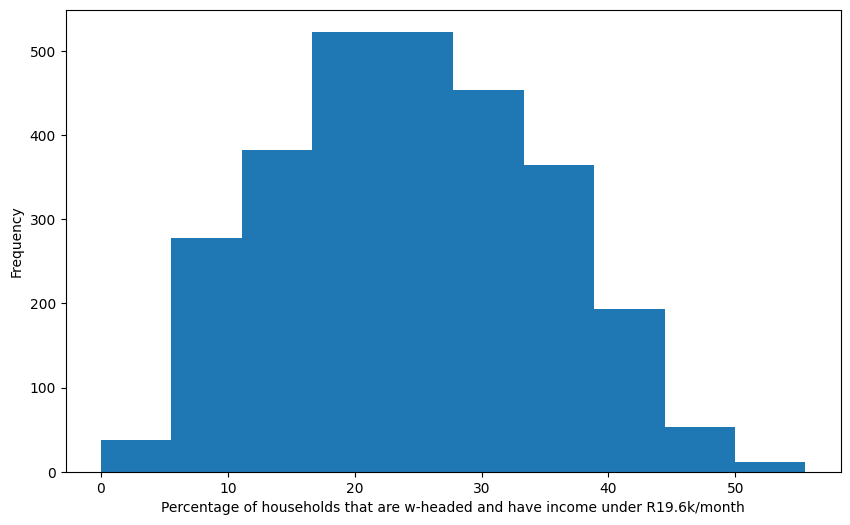

In [27]:
# show the histogram of the target variable
ax = df['target'].plot(kind='hist')
plt.xlabel('Percentage of households that are w-headed and have income under R19.6k/month')

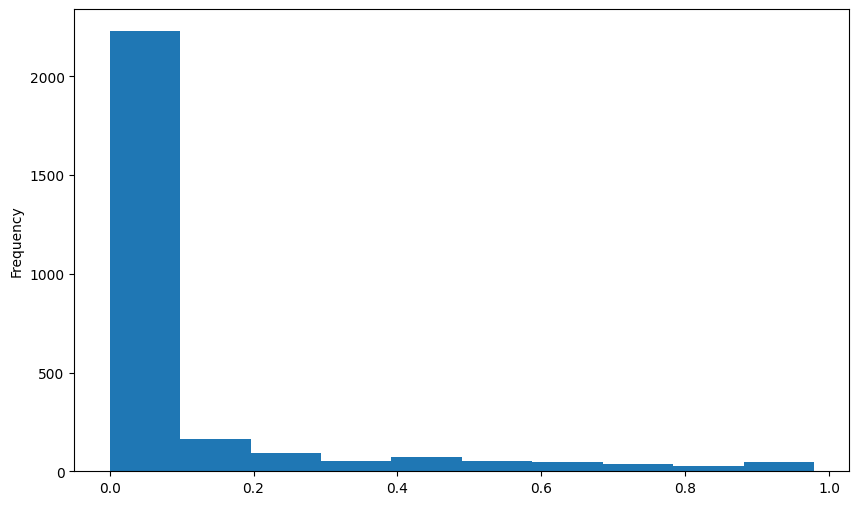

In [28]:
# show the histogram of 'Percentage listing language as'
ax = df['Percentage listing language as'].plot(kind='hist')

array([[<Axes: title={'center': 'ward'}>,
        <Axes: title={'center': 'total_households'}>,
        <Axes: title={'center': 'total_individuals'}>,
        <Axes: title={'center': 'target'}>,
        <Axes: title={'center': 'Percentage of dwellings of type'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.1'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.2'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.3'}>],
       [<Axes: title={'center': 'Percentage of dwellings of type.4'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.5'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.6'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.7'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.8'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.9'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.10'}>,
        <Axes: title={'c

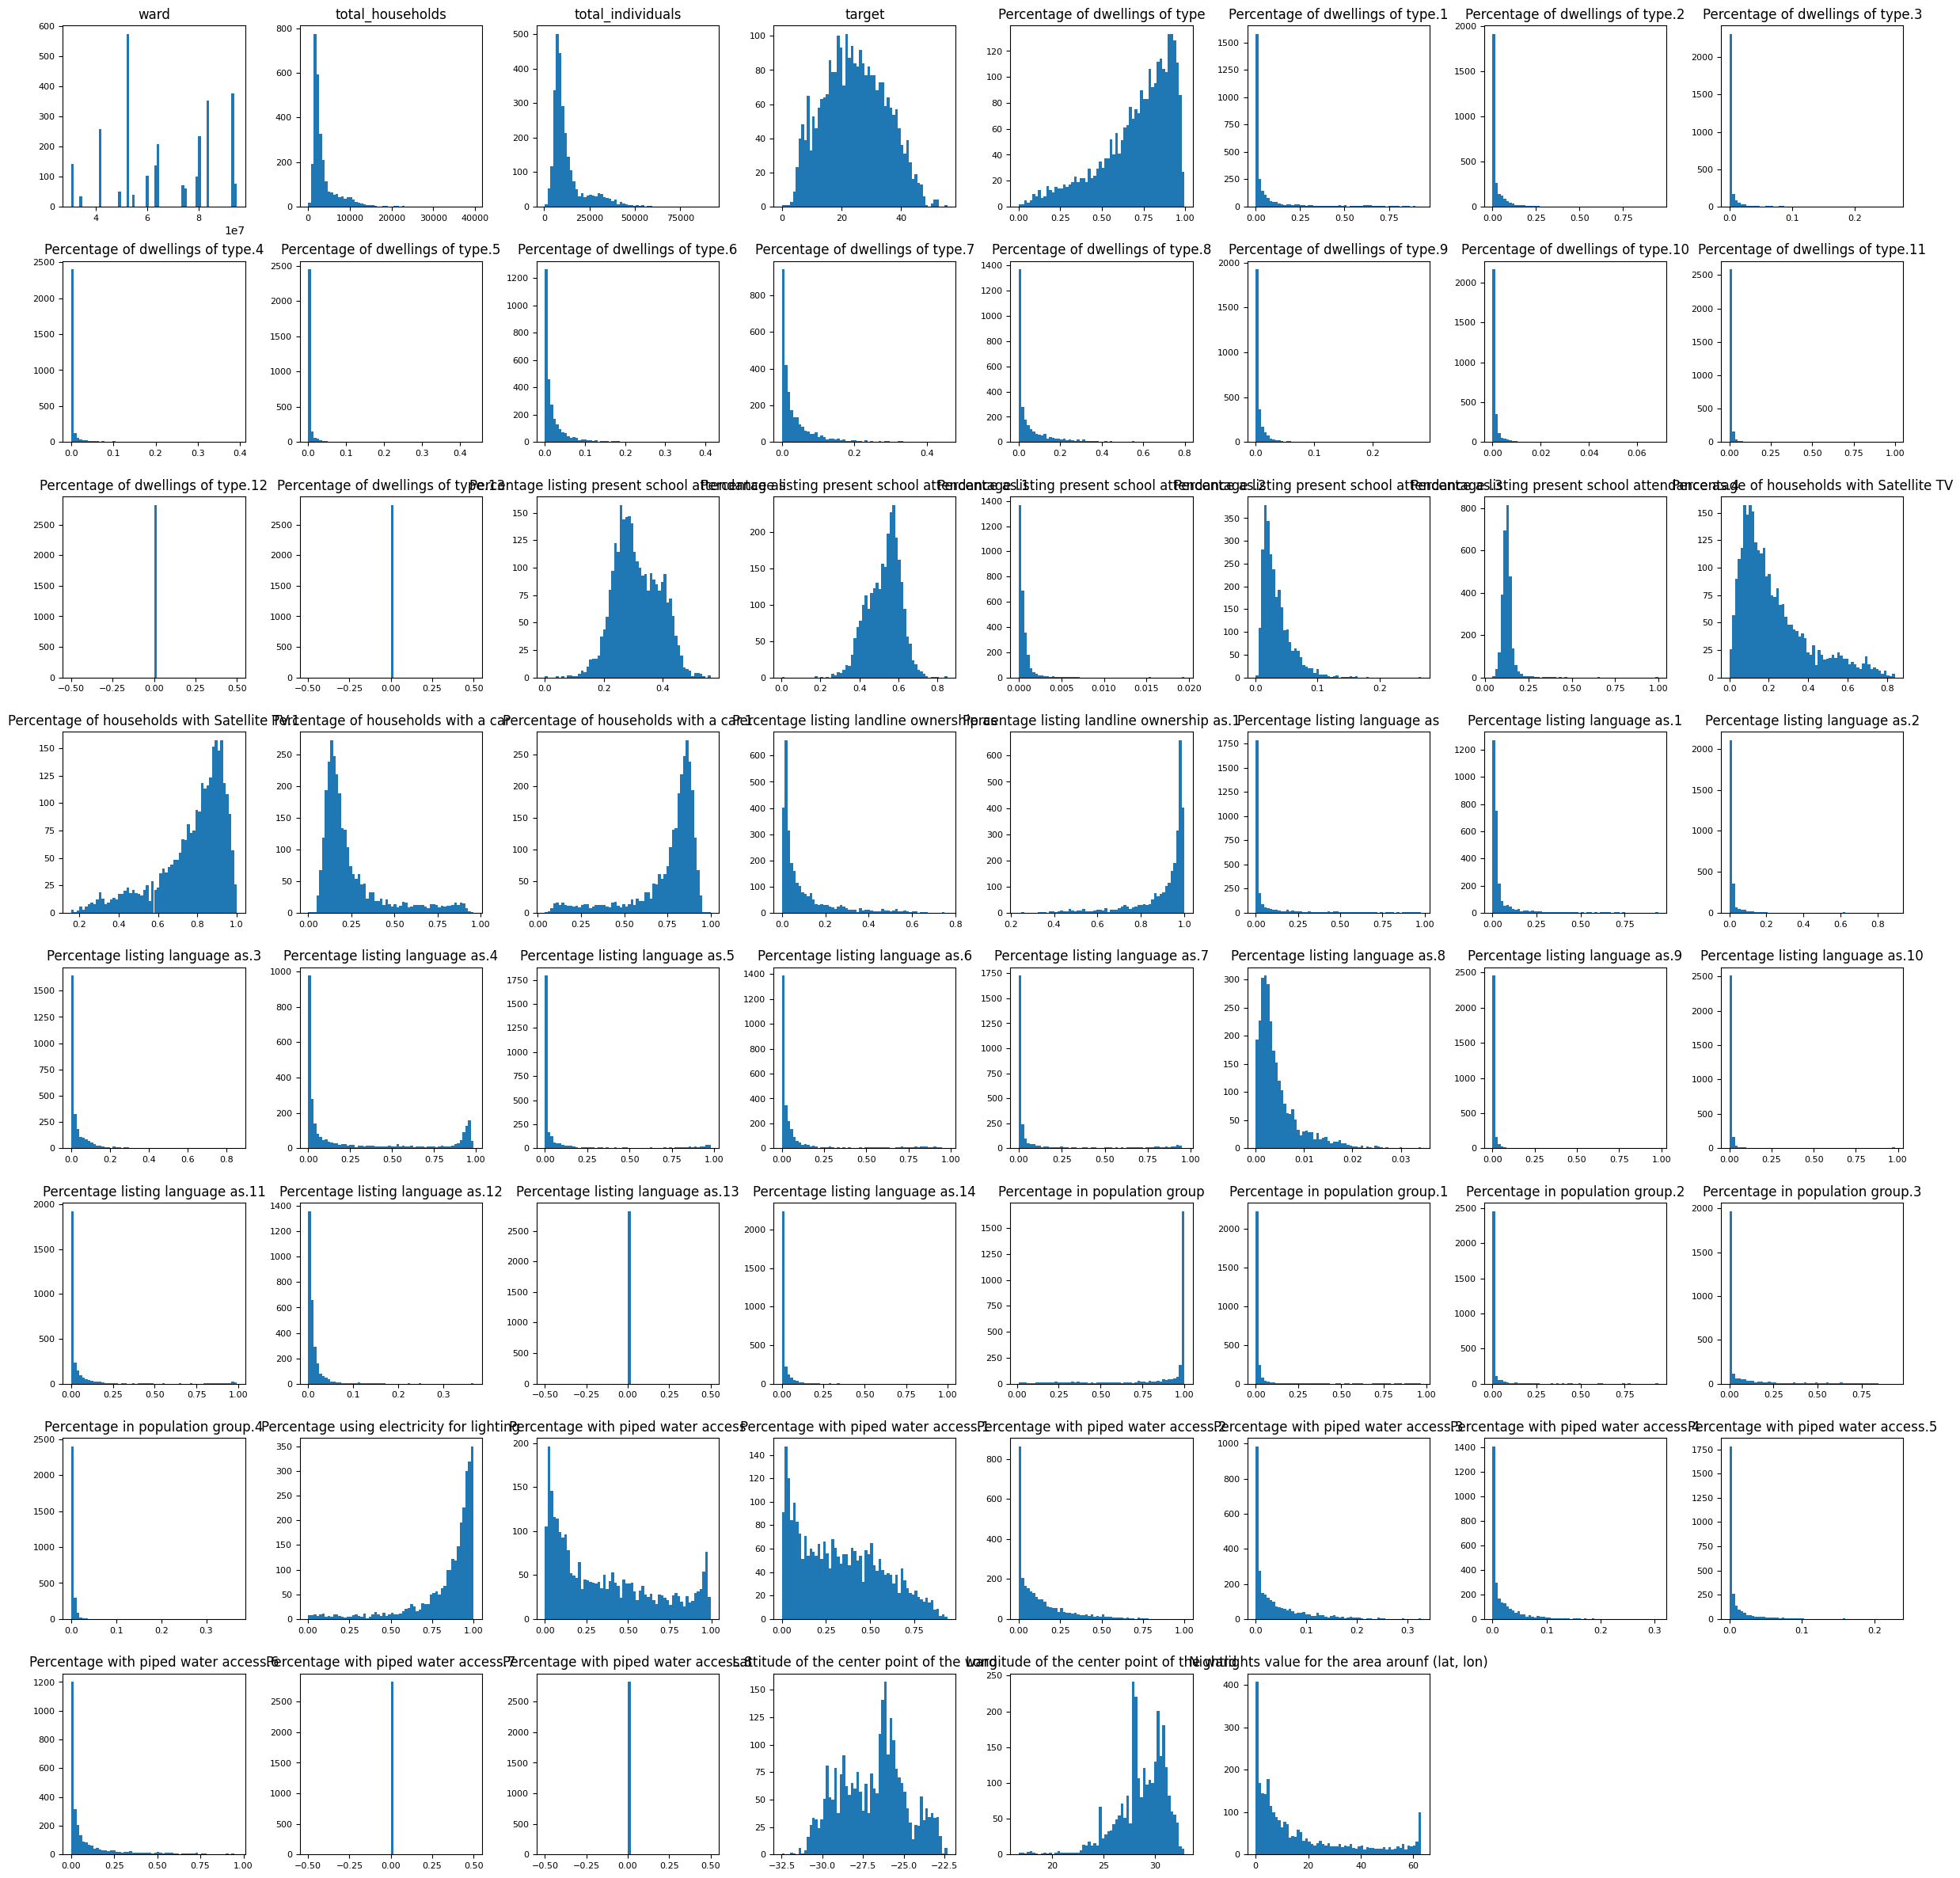

In [29]:
# show the histogram of all df
df.hist(xlabelsize=8, ylabelsize=8, bins=60, figsize=(30, 30), grid=False)

array([[<Axes: title={'center': 'total_households'}>,
        <Axes: title={'center': 'total_individuals'}>,
        <Axes: title={'center': 'Percentage of dwellings of type'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.1'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.2'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.3'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.4'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.5'}>],
       [<Axes: title={'center': 'Percentage of dwellings of type.6'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.7'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.8'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.9'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.10'}>,
        <Axes: title={'center': 'Percentage of dwellings of type.11'}>,
        <Axes: title={'center': 'Perce

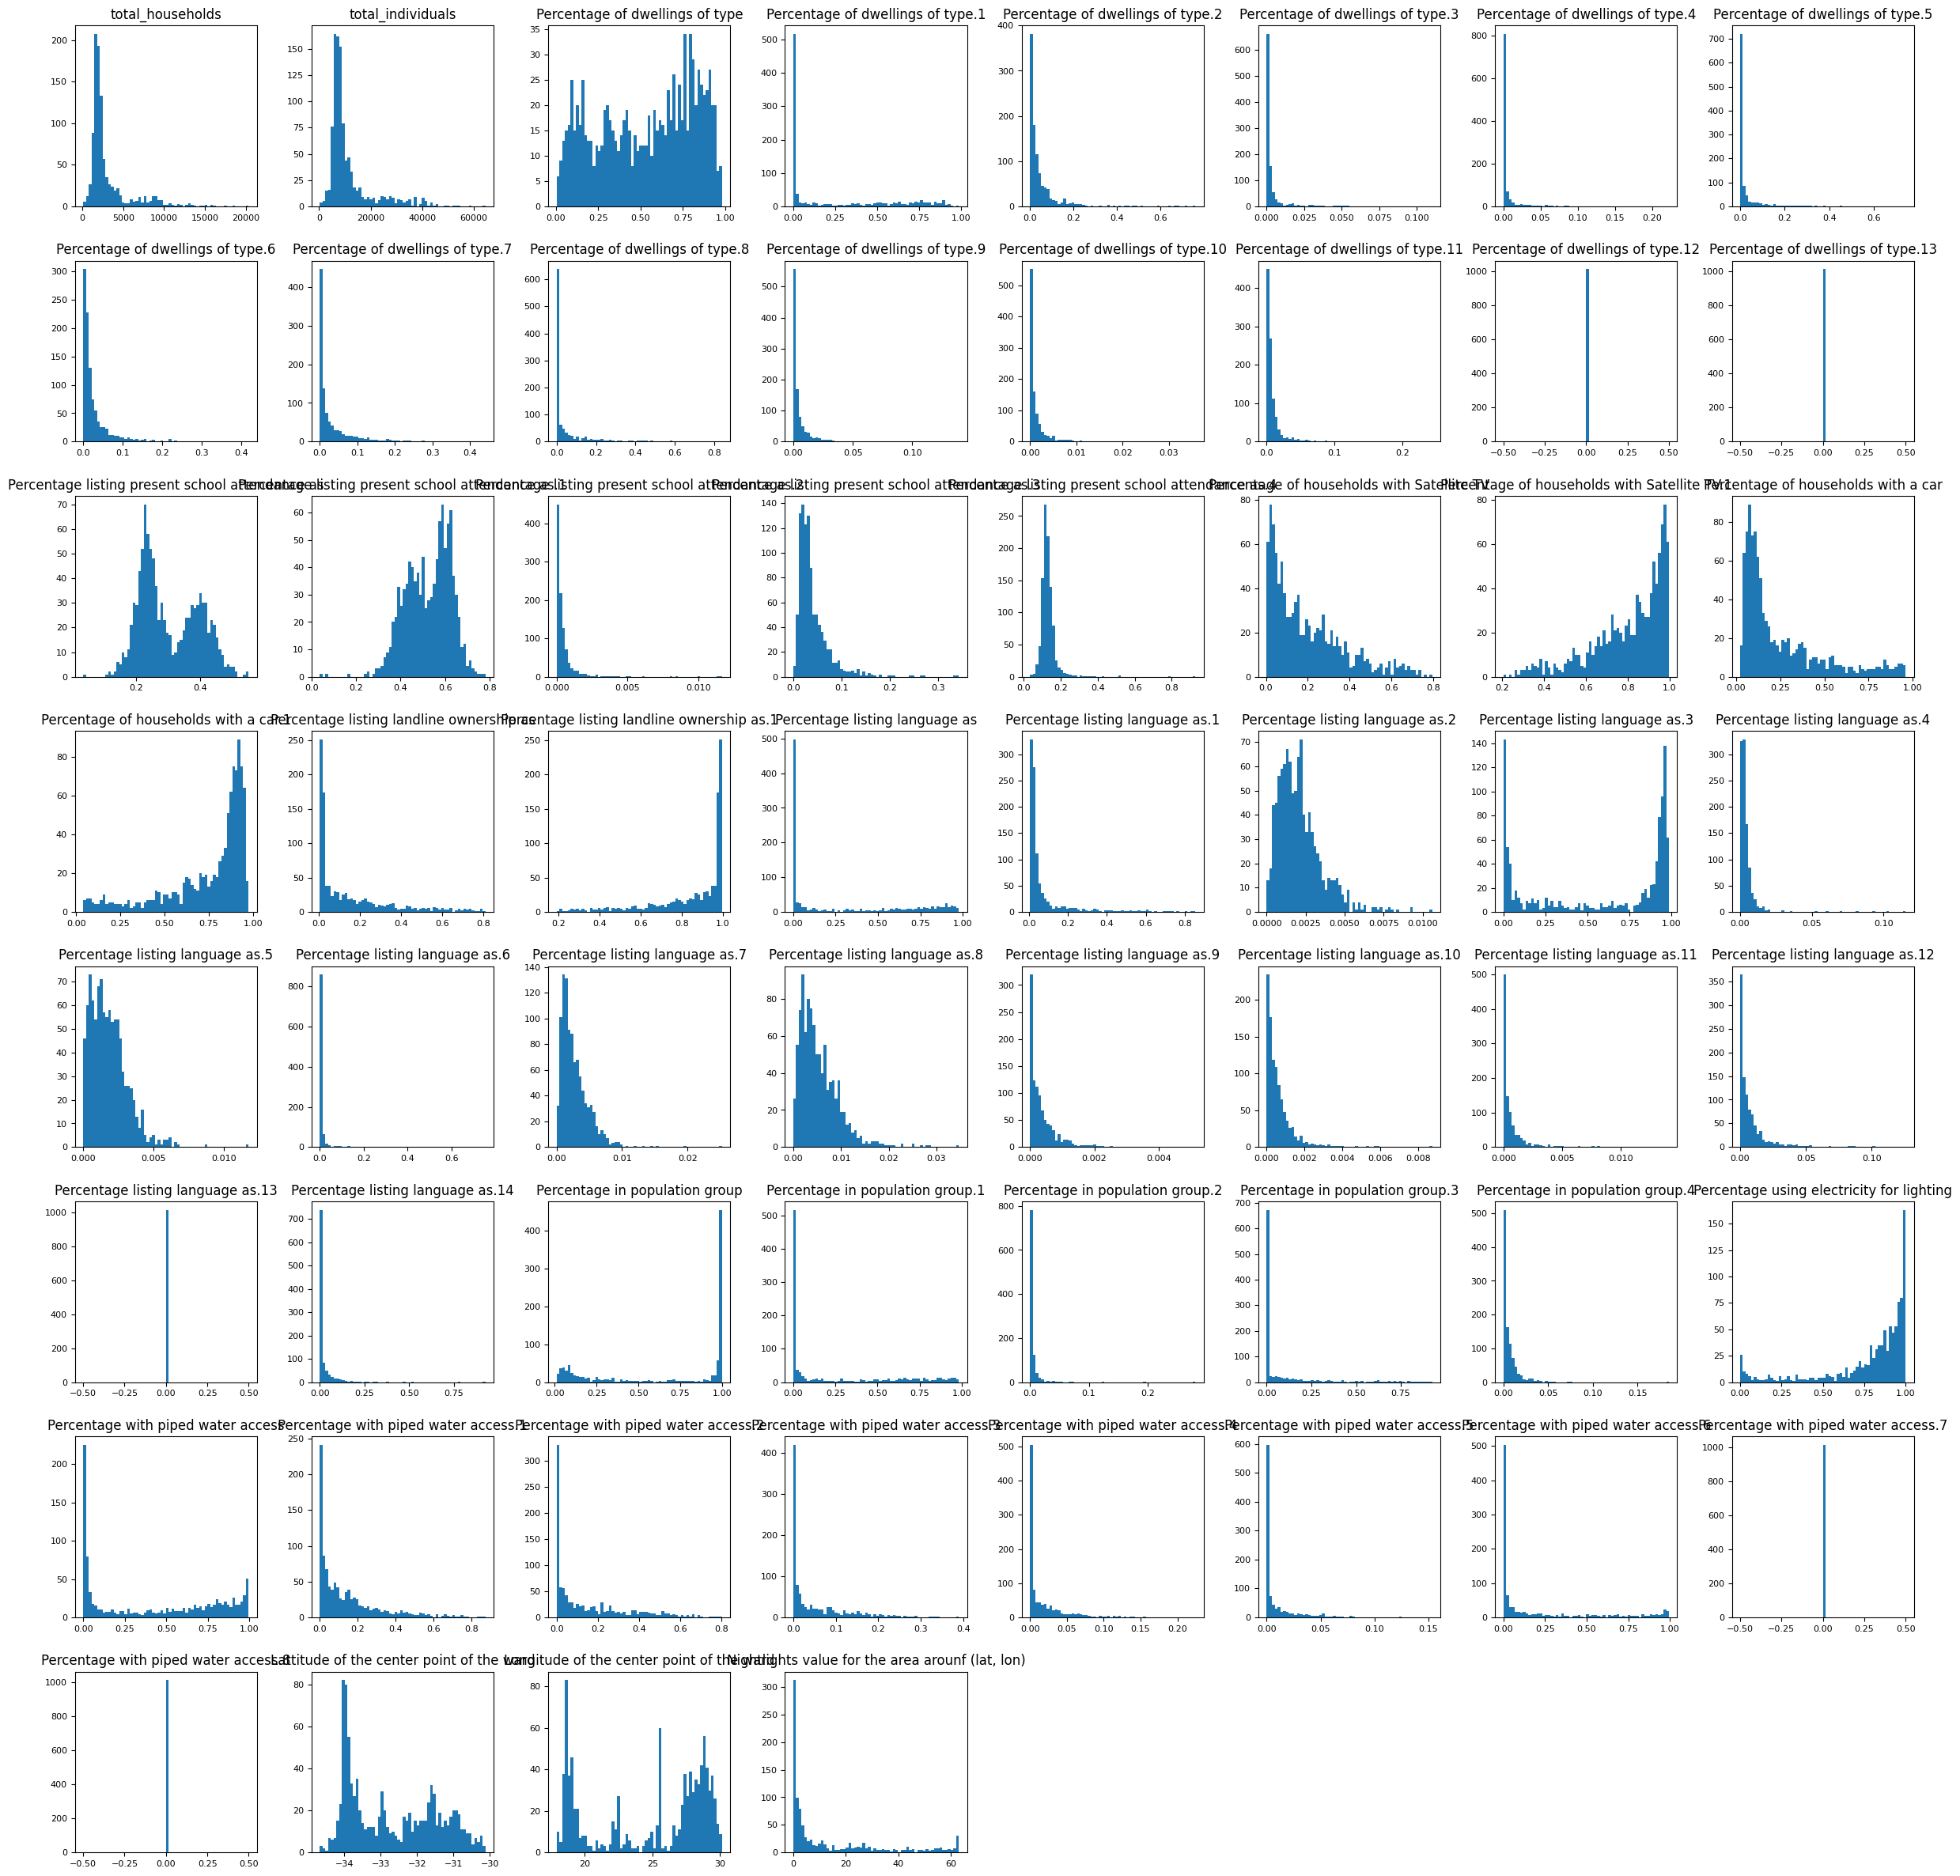

In [30]:
# show the histogram of all test
test.hist(xlabelsize=8, ylabelsize=8, bins=60, figsize=(30, 30), grid=False)

In [31]:
import plotly.express as px

fig = px.scatter_mapbox(df, lat="Lattitude of the center point of the ward", lon="Longitude of the center point of the ward", hover_name="ward", hover_data=["target"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

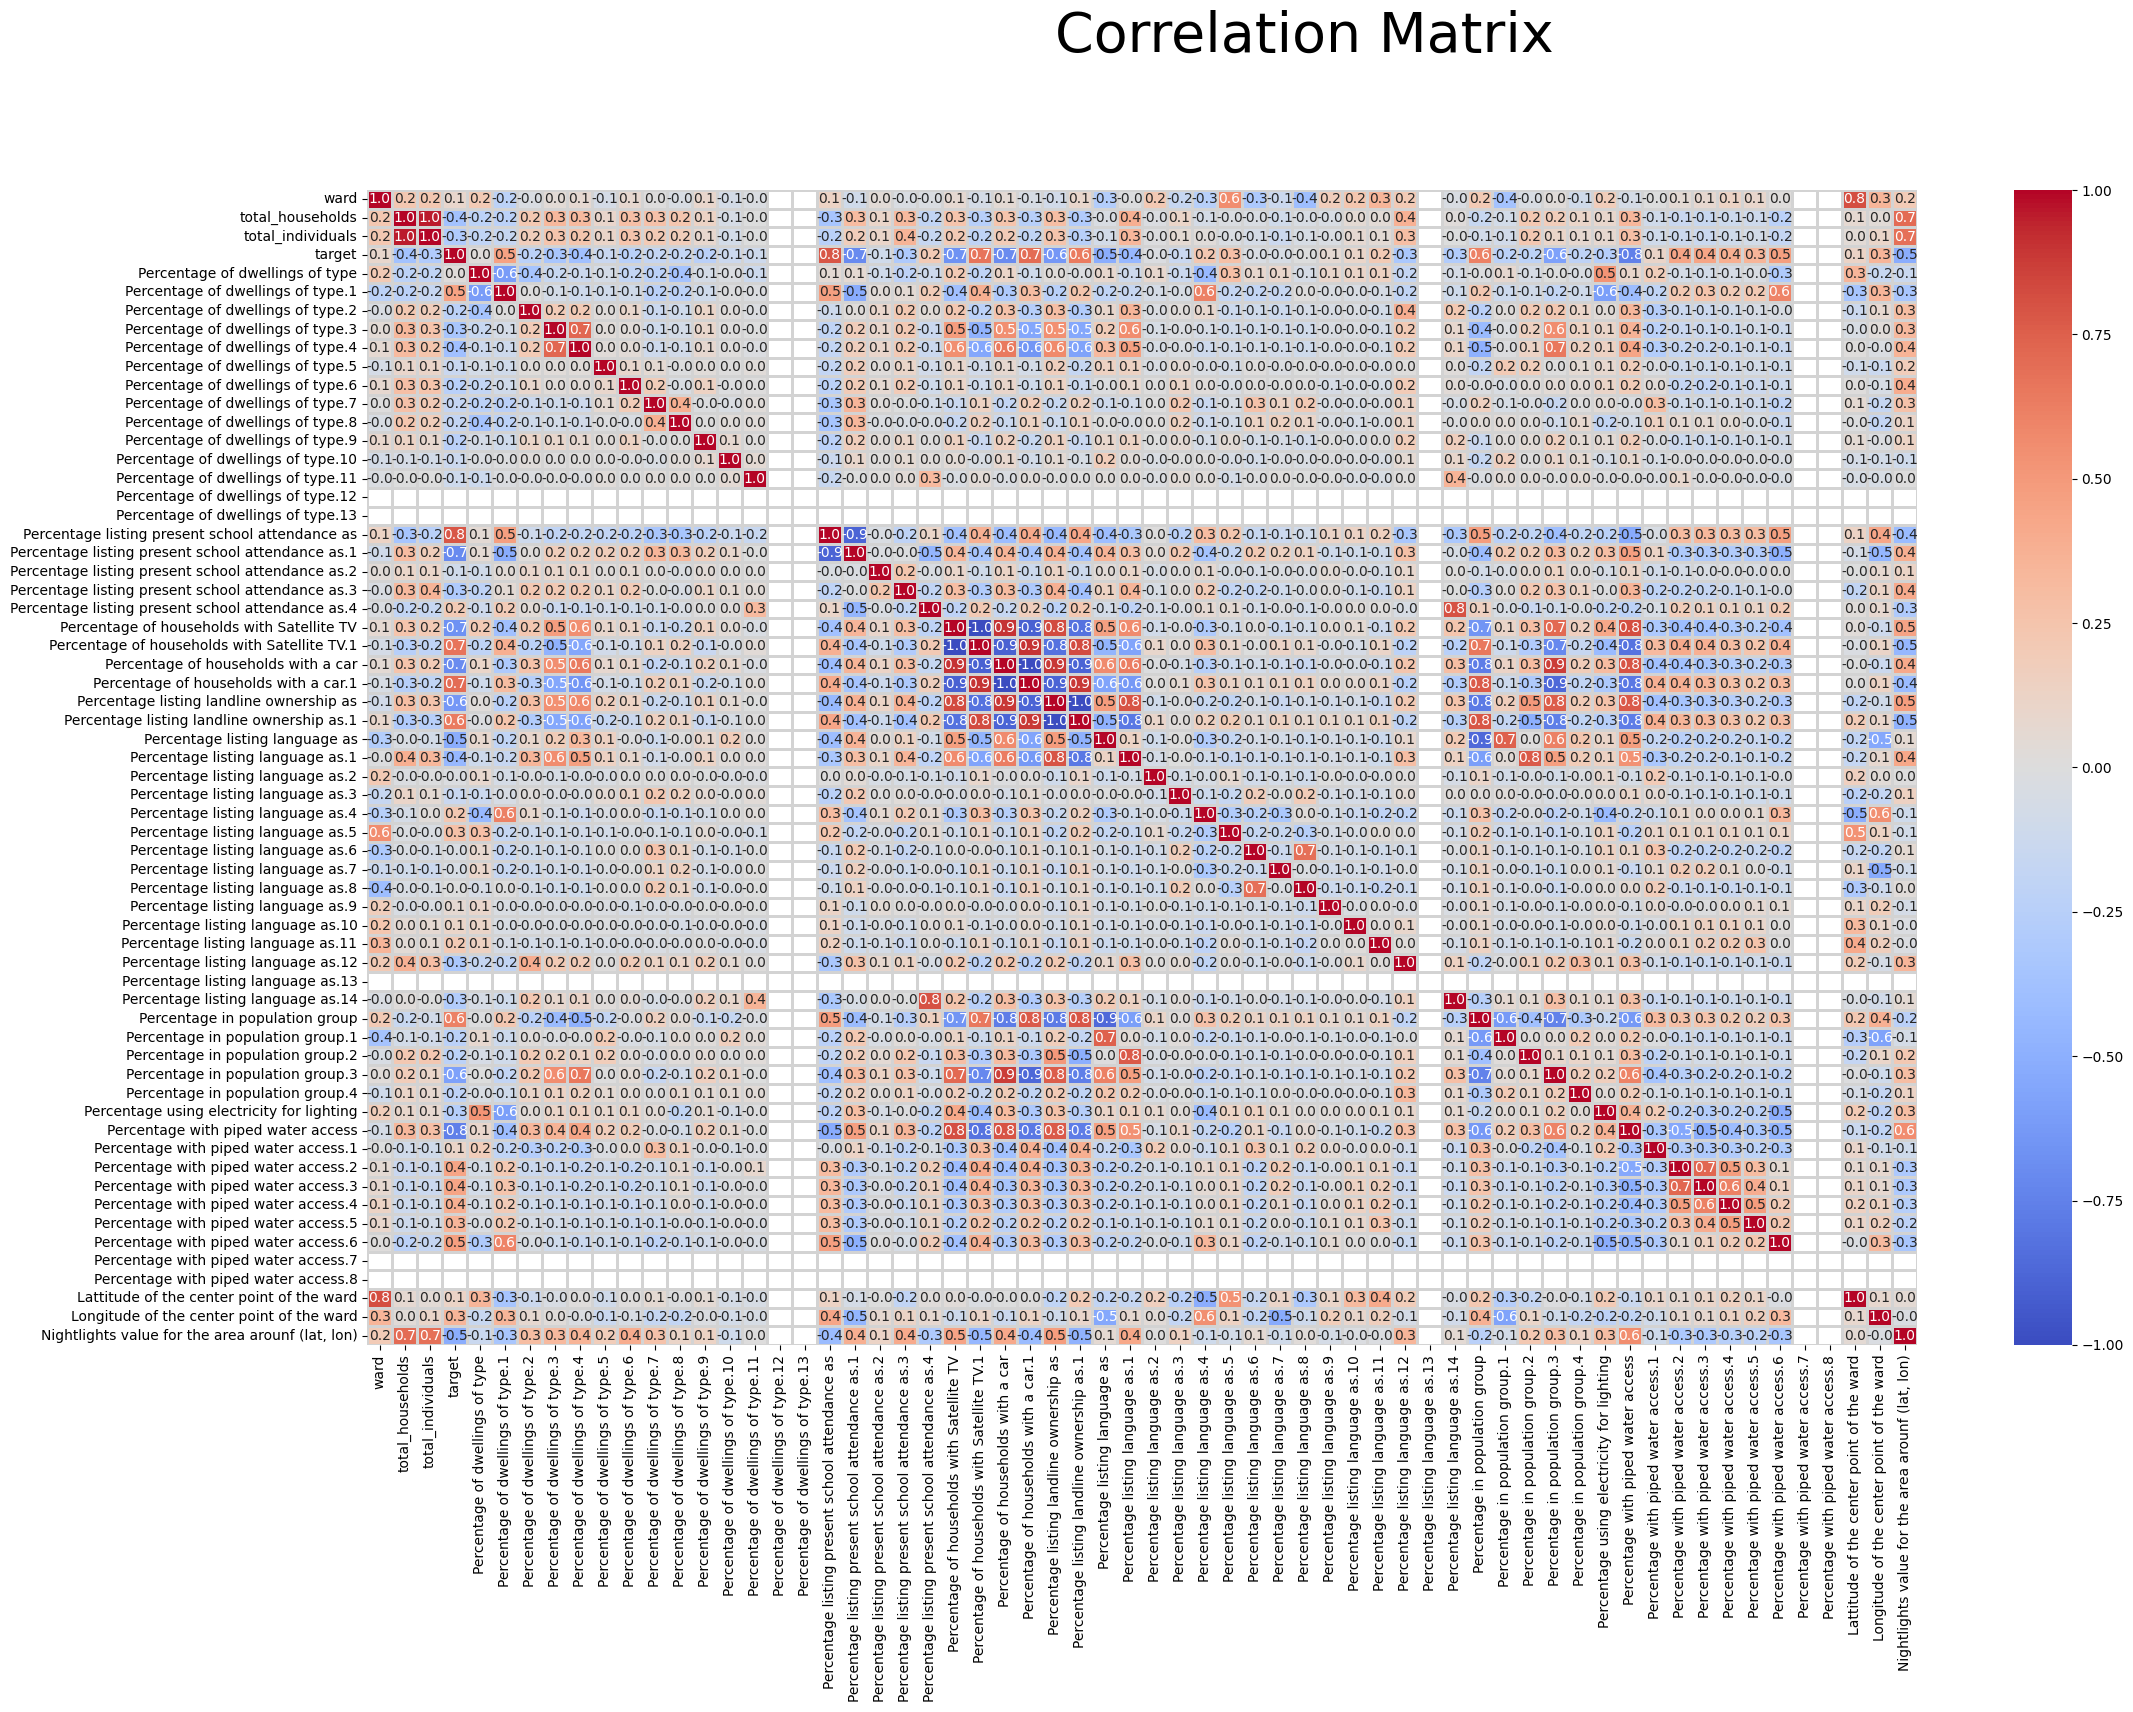

In [32]:
# Show the correlation matrix
plt.figure(figsize=(25, 15))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt='.1f', linewidths=2, linecolor='lightgrey')
plt.suptitle('Correlation Matrix', fontsize=40, y=1)
plt.show()

In [33]:
# drop all features those filled with zeros
def drop_features_with_zeros(data):
  features_with_zeros_values = data.columns[data.eq(0).all()]
  data.drop(columns=features_with_zeros_values, inplace=True)

drop_features_with_zeros(df)
drop_features_with_zeros(test)

<Axes: xlabel='Percentage listing present school attendance as', ylabel='target'>

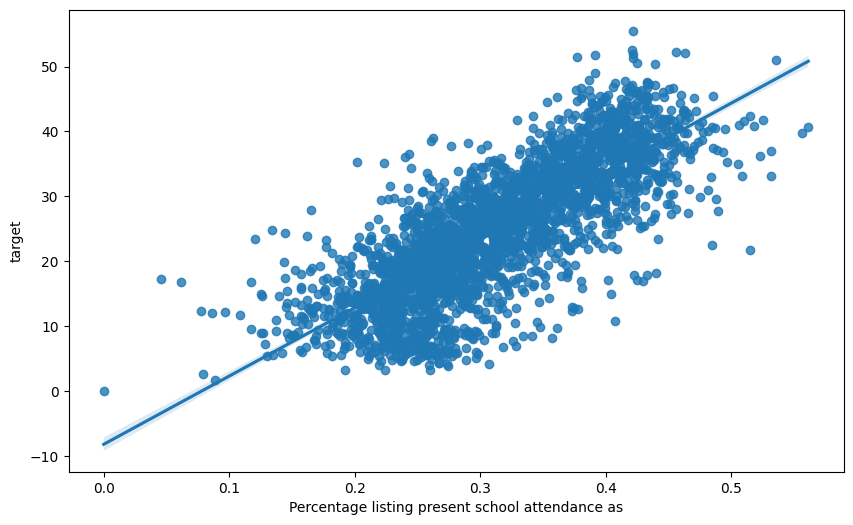

In [34]:
import seaborn as sns
sns.regplot(x='Percentage listing present school attendance as', y='target', data=df)

<Axes: xlabel='Percentage listing present school attendance as', ylabel='Count'>

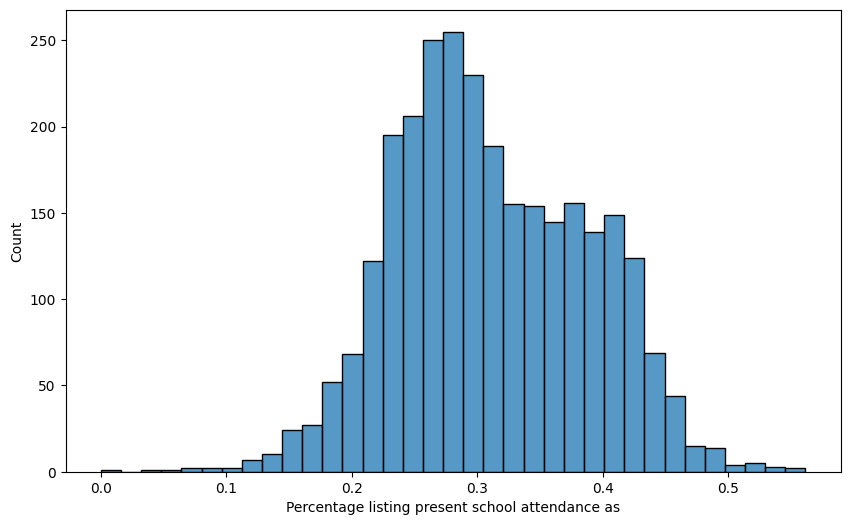

In [35]:
sns.histplot(df['Percentage listing present school attendance as'])

**Feature Engineering**

In [36]:
# define the function
def geospatial_features(data):
    """
    This function takes a DataFrame and computes geospatial features:
    1. H3 Index for hexagonal spatial indexing.
    2. Distance to the centroid of all points in the dataset.
    3. Spatial binning using a uniform grid.

    Parameters:
    data (DataFrame): Input DataFrame with latitude and longitude columns.

    Returns:
    DataFrame: Updated DataFrame with new geospatial features.
    """
    # Define H3 resolution level (controls the size of hexagonal cells)
    h3_resolution = 7

    # Convert latitude/longitude to H3 Index
    data["h3_index"] = data.apply(lambda row: h3.latlng_to_cell(
        row["Lattitude of the center point of the ward"],
        row["Longitude of the center point of the ward"],
        h3_resolution), axis=1) 

    # Calculate the centroid of all points in the dataset
    center_lat = data["Lattitude of the center point of the ward"].mean()
    center_lon = data["Longitude of the center point of the ward"].mean()
    center_point = (center_lat, center_lon)

    # Compute geodesic distance from each point to the dataset's centroid
    data["distance_to_center_km"] = data.apply(lambda row: geodesic(
        (row["Lattitude of the center point of the ward"], row["Longitude of the center point of the ward"]),
        center_point).kilometers, axis=1)

    # Define grid size for spatial binning (e.g., 0.01-degree grid)
    grid_size = 0.01

    # Convert latitude/longitude coordinates into a uniform grid
    data["grid_x"] = (data["Lattitude of the center point of the ward"] / grid_size).astype(int)
    data["grid_y"] = (data["Longitude of the center point of the ward"] / grid_size).astype(int)

    return data

# Apply the function to the DataFrame
df = geospatial_features(df)
test = geospatial_features(test)


In [37]:
# Extract the columns with the same name and different suffixes from the dataframe
Percentage_listing_present_school_attendance_as = df[['Percentage listing present school attendance as', 'Percentage listing present school attendance as.1'
                      , 'Percentage listing present school attendance as.2', 'Percentage listing present school attendance as.3'
                      , 'Percentage listing present school attendance as.4']]
# Percentage_of_dwellings_of_type

Percentage_of_dwellings_of_type = df[['Percentage of dwellings of type','Percentage of dwellings of type.1', 'Percentage of dwellings of type.2', 'Percentage of dwellings of type.3'
    , 'Percentage of dwellings of type.4', 'Percentage of dwellings of type.5', 'Percentage of dwellings of type.6', 'Percentage of dwellings of type.7'
    , 'Percentage of dwellings of type.8', 'Percentage of dwellings of type.9', 'Percentage of dwellings of type.10', 'Percentage of dwellings of type.11']]

# Percentage_listing_language_as

Percentage_listing_language_as = df[['Percentage listing language as', 'Percentage listing language as.1', 'Percentage listing language as.2'
    , 'Percentage listing language as.3', 'Percentage listing language as.4', 'Percentage listing language as.5', 'Percentage listing language as.6'
    , 'Percentage listing language as.7', 'Percentage listing language as.8', 'Percentage listing language as.9', 'Percentage listing language as.10'
    , 'Percentage listing language as.11', 'Percentage listing language as.12',  'Percentage listing language as.14']]

# Percentage_in_population_group

Percentage_in_population_group = df[['Percentage in population group', 'Percentage in population group.1', 'Percentage in population group.2'
    , 'Percentage in population group.3', 'Percentage in population group.4']]

# Percentage_with_piped_water_access


Percentage_with_piped_water_access = df[['Percentage with piped water access', 'Percentage with piped water access.1', 'Percentage with piped water access.2'
                                         , 'Percentage with piped water access.3', 'Percentage with piped water access.4', 'Percentage with piped water access.5', 'Percentage with piped water access.6']]


In [38]:
Percentage_with_piped_water_access

Percentage with piped water access  \
0                               0.742692   
1                               0.309294   
2                               0.323393   
3                               0.677437   
4                               0.771106   
...                                  ...   
2817                            0.918325   
2818                            0.426518   
2819                            0.619392   
2820                            0.567853   
2821                            0.316055   

      Percentage with piped water access.1  \
0                                 0.214027   
1                                 0.576844   
2                                 0.483376   
3                                 0.314194   
4                                 0.194743   
...                                    ...   
2817                              0.074058   
2818                              0.557859   
2819                              0.326884   
2820                              0.301241   
2821                              0.666294   

      Percentage with piped water access.2  \
0                                 0.019968   
1                                 0.018946   
2                                 0.083010   
3                                 0.002689   
4                                 0.009699   
...                                    ...   
2817                              0.000472   
2818                              0.003467   
2819                              0.046445   
2820                              0.108998   
2821                              0.010805   

      Percentage with piped water access.3  \
0                                 0.002848   
1                                 0.014566   
2                                 0.057560   
3                                 0.000000   
4                                 0.004859   
...                                    ...   
2817                              0.000472   
2818                              0.003030   
2819                              0.002150   
2820                              0.009235   
2821                              0.003107   

      Percentage with piped water access.4  \
0                                 0.007537   
1                                 0.057127   
2                                 0.010358   
3                                 0.000669   
4                                 0.001290   
...                                    ...   
2817                              0.000472   
2818                              0.000713   
2819                              0.001458   
2820                              0.007870   
2821                              0.001636   

      Percentage with piped water access.5  \
0                                 0.000000   
1                                 0.019092   
2                                 0.001421   
3                                 0.000000   
4                                 0.000673   
...                                    ...   
2817                              0.000000   
2818                              0.000000   
2819                              0.000000   
2820                              0.000000   
2821                              0.000332   

      Percentage with piped water access.6  
0                                 0.012928  
1                                 0.004131  
2                                 0.040881  
3                                 0.005011  
4                                 0.017629  
...                                    ...  
2817                              0.006203  
2818                              0.008414  
2819                              0.003670  
2820                              0.004803  
2821                              0.001770  

[2822 rows x 7 columns]

In [39]:
Percentage_of_households_with_Satellite_TV = df[['Percentage of households with Satellite TV', 'Percentage of households with Satellite TV.1']]
df['Percentage of households with Satellite TV abs'] = abs(df['Percentage of households with Satellite TV'] - df['Percentage of households with Satellite TV.1'])
test['Percentage of households with Satellite TV abs'] = abs(test['Percentage of households with Satellite TV'] - test['Percentage of households with Satellite TV.1'])

In [40]:
# Get the mean of 'Percentage of dwellings of type' and 'Percentage of dwellings of type.2'
df['Percentage of dwellings of type mean'] = (df['Percentage of dwellings of type'] + df['Percentage of dwellings of type.1'])/2
test['Percentage of dwellings of type mean'] = (test['Percentage of dwellings of type'] + test['Percentage of dwellings of type.1'])/2

In [41]:
# calulate the total mean of 'total_households' and 'total_individuals'
df['total mean'] = (df['total_households'] + df['total_individuals'])/2
test['total mean'] = (test['total_households'] + test['total_individuals'])/2

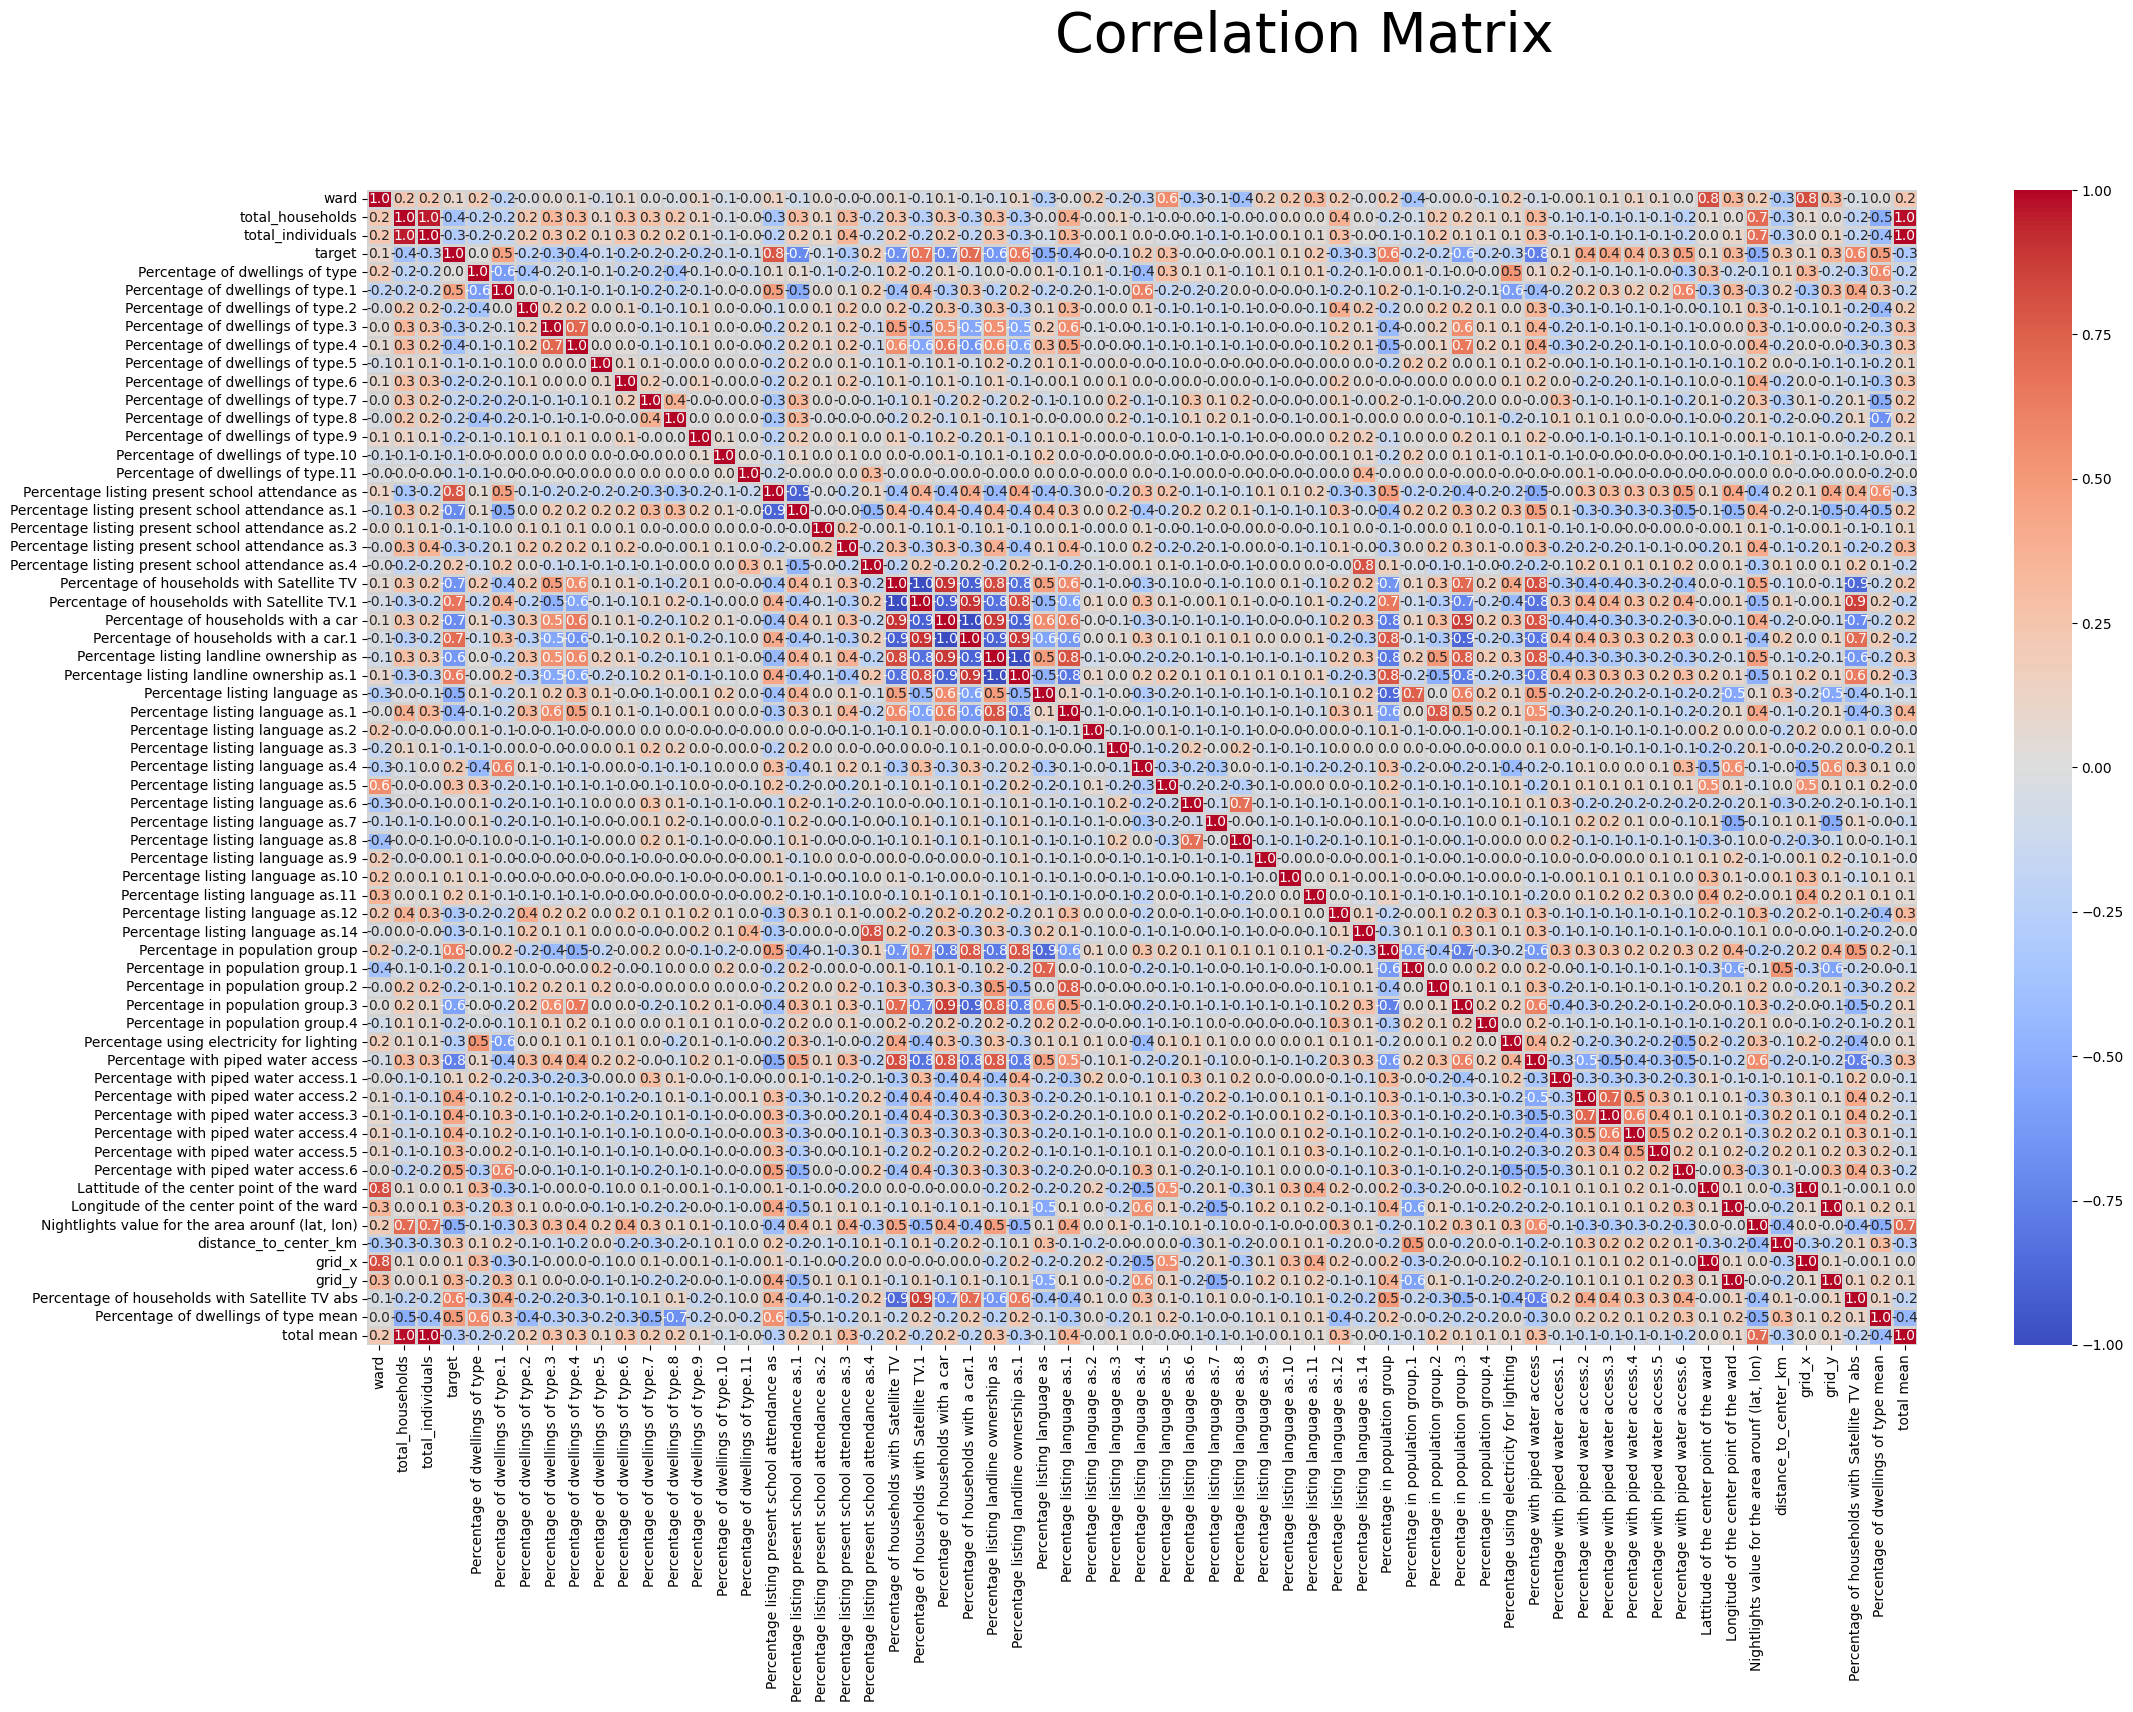

In [42]:
plt.figure(figsize=(25, 15))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt='.1f', linewidths=2, linecolor='lightgrey')
plt.suptitle('Correlation Matrix', fontsize=40, y=1)
plt.show()

In [43]:
# select the features to use them in the model
Selected_features2 =  ["distance_to_center_km", "grid_x", "grid_y",'ward', 'total_households', 'total_individuals', 'Percentage of dwellings of type.1', 'Percentage of dwellings of type.2', 'Percentage of dwellings of type.3', 'Percentage of dwellings of type.4', 'Percentage of dwellings of type.5', 'Percentage of dwellings of type.6', 'Percentage of dwellings of type.7', 'Percentage of dwellings of type.8', 'Percentage of dwellings of type.9', 'Percentage of dwellings of type.10', 'Percentage of dwellings of type.11', 'Percentage listing present school attendance as', 'Percentage listing present school attendance as.1', 'Percentage listing present school attendance as.2', 'Percentage listing present school attendance as.3', 'Percentage listing present school attendance as.4', 'Percentage of households with Satellite TV', 'Percentage of households with Satellite TV.1', 'Percentage of households with a car', 'Percentage of households with a car.1', 'Percentage listing landline ownership as', 'Percentage listing landline ownership as.1', 'Percentage listing language as', 'Percentage listing language as.1', 'Percentage listing language as.3', 'Percentage listing language as.4', 'Percentage listing language as.5', 'Percentage listing language as.6', 'Percentage listing language as.7', 'Percentage listing language as.8', 'Percentage listing language as.9', 'Percentage listing language as.10', 'Percentage listing language as.11', 'Percentage listing language as.12', 'Percentage listing language as.14', 'Percentage in population group.1', 'Percentage in population group.2', 'Percentage in population group.3', 'Percentage in population group.4', 'Percentage using electricity for lighting', 'Percentage with piped water access', 'Percentage with piped water access.1', 'Percentage with piped water access.2', 'Percentage with piped water access.3', 'Percentage with piped water access.4', 'Percentage with piped water access.5', 'Percentage with piped water access.6', 'Lattitude of the center point of the ward', 'Longitude of the center point of the ward', 'Nightlights value for the area arounf (lat, lon)', 'Percentage of households with Satellite TV abs', 'Percentage of dwellings of type mean', 'total mean']

In [44]:
X = df[Selected_features2]
y = df['target']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [45]:
# show the shape of the splitted data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2257, 59), (565, 59), (2257,), (565,))

In [46]:
# Define KFold cross-validation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd

n_splits = 7
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store RMSE scores
rmse_scores = []

# iterate through each fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_fold_train, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize models
    model_hist = HistGradientBoostingRegressor()
    model_catboost = CatBoostRegressor(iterations=1600, loss_function='RMSE', verbose=0)

    
    # Train models
    model_hist.fit(X_fold_train, y_fold_train)
    model_catboost.fit(X_fold_train, y_fold_train)
    
    
    # Predict
    model_hist = model_hist.predict(X_val)
    y_pred_catboost = model_catboost.predict(X_val)
    
    # Average predictions (Blending approach)
    y_pred_ensemble = (y_pred_catboost + model_hist + y_pred_catboost  +y_pred_catboost ) / 4
    
    # Calculate RMSE
    mse = mean_squared_error(y_val, y_pred_ensemble)
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)
    print(f"Fold {fold + 1}: RMSE = {rmse}")

# Print average RMSE
print(f"Average RMSE across {n_splits} folds: {np.mean(rmse_scores)}")

# Average RMSE across 7 folds: 3.2167950241724883

Fold 1: RMSE = 3.6943847550151543
Fold 2: RMSE = 3.2732497094643502
Fold 3: RMSE = 3.0628926902095786
Fold 4: RMSE = 3.3227522280048216
Fold 5: RMSE = 2.9307200835408884
Fold 6: RMSE = 3.1321552190275925
Fold 7: RMSE = 3.101410483945036
Average RMSE across 7 folds: 3.2167950241724883


In [47]:
# Train the final model on the entire training set
model_hist = HistGradientBoostingRegressor()
model_catboost_final = CatBoostRegressor(iterations=1600, loss_function='RMSE', verbose=0)

model_hist.fit(X_train, y_train)
model_catboost_final.fit(X_train, y_train)

# Predict on Test Data
model_hist_test = model_hist.predict(X_test)
y_pred_catboost_test = model_catboost_final.predict(X_test)

# Blended Predictions
y_pred_ensemble_test = (model_hist_test + y_pred_catboost_test + y_pred_catboost_test + y_pred_catboost_test) / 4

# Calculate Test RMSE
test_mse = mean_squared_error(y_test, y_pred_ensemble_test)
test_rmse = np.sqrt(test_mse)
print(f"Test RMSE: {test_rmse}")
# Test RMSE: 2.92245583026276

Test RMSE: 2.92245583026276


In [48]:
# train the model on entire X and y
model_hist.fit(X, y)
model_catboost_final.fit(X, y)

In [49]:
# prompt: get the final prediction

test['ward'] = sample['ward'].str.replace(r':.*\d+', '', regex=True)
test['ward'] = pd.to_numeric(test['ward'], errors='coerce')

# Make sure the test data has the same columns as the training data
test_data = test[X_train.columns]

# Predict using both models
final_predictions_hist = model_hist.predict(test_data)
final_predictions_catboost = model_catboost_final.predict(test_data)

# Combine predictions (Blending)
final_predictions = (final_predictions_hist + final_predictions_catboost + final_predictions_catboost + final_predictions_catboost) / 4

# print the final predictions
final_predictions
# array([19.48231581, 13.26138351, 21.53789168, ..., 17.5725221 , 14.20303045, 18.05145589])

array([19.48231581, 13.26138351, 21.53789168, ..., 17.5725221 ,
       14.20303045, 18.05145589])

In [50]:
# Create a DataFrame for submission
submission_df = pd.DataFrame({'ward': sample['ward'], 'target': final_predictions})

# Save the DataFrame to a CSV file
submission_df.to_csv('fional.csv', index=False)


C:\Users\Yousif shaheen\AppData\Local\Temp\ipykernel_22216\29839167.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




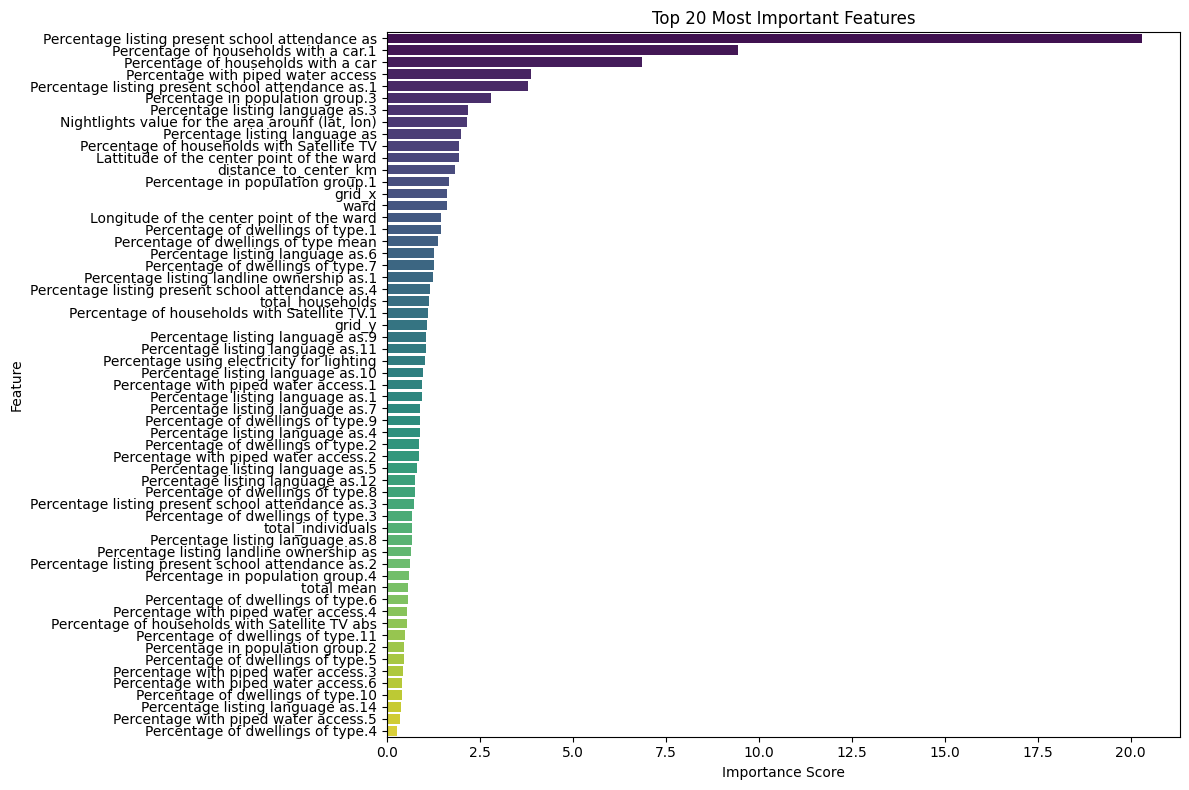


Top 20 Most Important Features:
                                          Feature  Importance
  Percentage listing present school attendance as   20.313488
            Percentage of households with a car.1    9.445067
              Percentage of households with a car    6.860196
               Percentage with piped water access    3.884001
Percentage listing present school attendance as.1    3.788228
                 Percentage in population group.3    2.808771
                 Percentage listing language as.3    2.194146
 Nightlights value for the area arounf (lat, lon)    2.156192
                   Percentage listing language as    1.993175
       Percentage of households with Satellite TV    1.942352
        Lattitude of the center point of the ward    1.940817
                            distance_to_center_km    1.833641
                 Percentage in population group.1    1.676118
                                           grid_x    1.632081
                                     

In [51]:
# Get feature importances from the trained CatBoost model
feature_importances = model_catboost_final.feature_importances_

# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': feature_importances
})

# Sort by importance in descending order
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print the feature importance values
print("\nTop 20 Most Important Features:")
print(importance_df.to_string(index=False))

In [ ]:
notebook_end = time.time()  
print(f"Total Notebook Execution Time: {notebook_end - notebook_start:.2f} seconds")  

Total Notebook Execution Time: 221.68 seconds


'\nTotal Notebook Execution Time: 1022.54 second which is around 17 minutes to run.\nThis includes the time taken for data loading, preprocessing, model training, and evaluation.\nThe actual time may vary based on the system and environment.\n'